In [1]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2
%matplotlib inline

# Data prep

In [2]:
import pandas as pd
from math import isnan

from tqdm.auto import tqdm, trange

full_seq_df = pd.read_csv("./datasets/stanford-rna-3d-folding-2/train_sequences.csv")
train_label_df = pd.read_csv("./datasets/stanford-rna-3d-folding-2/train_labels.csv")

labels = ('x_1', 'y_1', 'z_1')

train_label_df['target_id'] = train_label_df['ID'].str.split('_', n=1).str[0]
train_label_df['pos'] = train_label_df['ID'].str.split('_', n=1).str[1].astype(int)

train_label_df = train_label_df.sort_values(['target_id', 'pos'])

for label in labels:
    first_mask = train_label_df.groupby('target_id')['pos'].transform('min') == train_label_df['pos']
    train_label_df.loc[first_mask & train_label_df[label].isna(), label] = 0
    train_label_df[label] = train_label_df.groupby('target_id')[label].ffill()

    assert not train_label_df[label].isna().any(), "label df has non-finite data"

max_allowed_len = 100_000

len_mask = full_seq_df['sequence'].str.len() <= max_allowed_len
full_seq_df = full_seq_df[len_mask].reset_index(drop=True)

seq_lengths = tuple(len(s) for s in full_seq_df['sequence'])
max_seq_len = max(seq_lengths)
print("Average length: ", sum(seq_lengths) / len(seq_lengths))
print("Min length:     ", min(seq_lengths))
print("Max length:     ", max_seq_len)

full_seq_df.head()
train_label_df.head()

/tmp/ipykernel_198999/1940882682.py:7: DtypeWarning: Columns (0: chain) have mixed types. Specify dtype option on import or set low_memory=False.
  train_label_df = pd.read_csv("./datasets/stanford-rna-3d-folding-2/train_labels.csv")


Average length:  1341.975678040245
Min length:      10
Max length:      16804


,ID,resname,resid,x_1,y_1,z_1,chain,copy,target_id,pos
0,157D_1,C,1,4.843,-5.640,13.265,A,1,157D,1
1,157D_2,G,2,3.385,-7.613,8.267,A,1,157D,2
2,157D_3,C,3,2.158,-6.751,2.949,A,1,157D,3
3,157D_4,G,4,2.669,-4.843,-1.773,A,1,157D,4
4,157D_5,A,5,3.509,0.239,-4.045,A,1,157D,5


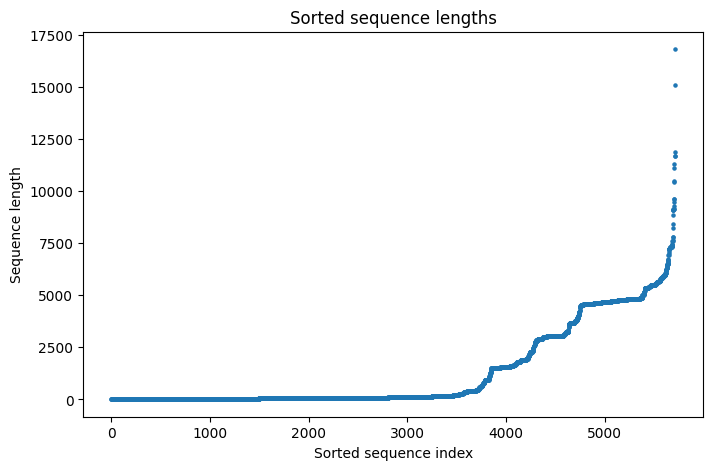

In [3]:
import matplotlib.pyplot as plt

sorted_lengths = sorted(seq_lengths)

plt.figure(figsize=(8, 5))

plt.scatter(range(len(sorted_lengths)), sorted_lengths, s=5)
plt.xlabel("Sorted sequence index")
plt.ylabel("Sequence length")
plt.title("Sorted sequence lengths")
plt.show()

In [4]:
def get_token_map():
    token_map = {}
    tokens = "ACGU "
    i = 1
    for c1 in tokens:
        for c2 in tokens:
            if c2 == ' ':
                continue
            for c3 in tokens:
                token_map[c1 + c2 + c3] = i
                i += 1
    return token_map

token_map = get_token_map()

print(token_map)

{'AAA': 1, 'AAC': 2, 'AAG': 3, 'AAU': 4, 'AA ': 5, 'ACA': 6, 'ACC': 7, 'ACG': 8, 'ACU': 9, 'AC ': 10, 'AGA': 11, 'AGC': 12, 'AGG': 13, 'AGU': 14, 'AG ': 15, 'AUA': 16, 'AUC': 17, 'AUG': 18, 'AUU': 19, 'AU ': 20, 'CAA': 21, 'CAC': 22, 'CAG': 23, 'CAU': 24, 'CA ': 25, 'CCA': 26, 'CCC': 27, 'CCG': 28, 'CCU': 29, 'CC ': 30, 'CGA': 31, 'CGC': 32, 'CGG': 33, 'CGU': 34, 'CG ': 35, 'CUA': 36, 'CUC': 37, 'CUG': 38, 'CUU': 39, 'CU ': 40, 'GAA': 41, 'GAC': 42, 'GAG': 43, 'GAU': 44, 'GA ': 45, 'GCA': 46, 'GCC': 47, 'GCG': 48, 'GCU': 49, 'GC ': 50, 'GGA': 51, 'GGC': 52, 'GGG': 53, 'GGU': 54, 'GG ': 55, 'GUA': 56, 'GUC': 57, 'GUG': 58, 'GUU': 59, 'GU ': 60, 'UAA': 61, 'UAC': 62, 'UAG': 63, 'UAU': 64, 'UA ': 65, 'UCA': 66, 'UCC': 67, 'UCG': 68, 'UCU': 69, 'UC ': 70, 'UGA': 71, 'UGC': 72, 'UGG': 73, 'UGU': 74, 'UG ': 75, 'UUA': 76, 'UUC': 77, 'UUG': 78, 'UUU': 79, 'UU ': 80, ' AA': 81, ' AC': 82, ' AG': 83, ' AU': 84, ' A ': 85, ' CA': 86, ' CC': 87, ' CG': 88, ' CU': 89, ' C ': 90, ' GA': 91, ' GC': 

In [5]:
downscale = 900

In [6]:
def get_coord_map(df) -> list:
    id_map = {}
    total = 0
    min_found = 0
    max_found = 0
    for row in tqdm(df.itertuples(index=False), desc = "Build id->coordinate map", total=len(df)):
        data = [row.x_1, row.y_1, row.z_1]
        id_map.setdefault(row.target_id, []).append(data)

    for shape in tqdm(id_map.values(), desc = "Center the dataset"):
        mean_x = sum(x for x, y, z in shape) / len(shape)
        mean_y = sum(y for x, y, z in shape) / len(shape)
        mean_z = sum(z for x, y, z in shape) / len(shape)
        for i in range(len(shape)):
            shape[i][0] -= mean_x
            shape[i][1] -= mean_y
            shape[i][2] -= mean_z
            
            shape[i][0] /= downscale
            shape[i][1] /= downscale
            shape[i][2] /= downscale

    for shape in tqdm(id_map.values(), desc = "Gather dataset stats"):
        for point in shape:
            total += sum(point)
            for coord in point:
                min_found = min(coord, min_found)
                max_found = max(coord, max_found)
    
    print("Average subcomponent magnitude: ", total / len(df) / 3)
    print("Min subcomponent magnitude:     ", min_found)
    print("Max subcomponent magnitude:     ", max_found)
    
    return id_map

id_map = get_coord_map(train_label_df)

Build id->coordinate map:   0%|          | 0/7794971 [00:00<?, ?it/s]

Center the dataset:   0%|          | 0/5716 [00:00<?, ?it/s]

Gather dataset stats:   0%|          | 0/5716 [00:00<?, ?it/s]

Average subcomponent magnitude:  -4.007107892716429e-18
Min subcomponent magnitude:      -0.9765611333333333
Max subcomponent magnitude:      0.9929986484312788


# NN Stuff

In [7]:
from ember import Learner

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from collections import deque
from time import time

torch.backends.cuda.matmul.allow_tf32 = True

In [8]:
bs = 64
test_bs = 16
num_epochs = 50

In [9]:
def split_str(k, s):
    return [s[i:i+k] for i in range(len(s)-k+1)]

In [10]:
def get_seq_by_id(id: str) -> str:
    if '_' in id:
        id = id.split('_')[0]
    for i, row in train_seq_df.iterrows():
        if row['target_id'] == id:
            return row['sequence']
    return None

In [11]:
def encode(seq: str):
    str_tokens = split_str(3, seq)
    tokens = [token_map[key] for key in str_tokens]
    return torch.tensor(tokens, dtype=torch.long)

In [12]:
class TensorWrapper():
    def __init__(self, *args):
        self.x = args
    
    def to(self, device):
        self.x = tuple(x.to(device) for x in self.x)
        return self

    def get(self):
        return self.x

In [13]:
class RNADataset(Dataset):
    def __init__(self, seq_df, label_df):
        self.seq = seq_df
        self.label = label_df

        print(f"Found {len(self):,} data points")
        
    def __getitem__(self, idx):
        row = self.seq.iloc[idx]
        target_id = row['target_id']

        target_tensor = torch.tensor(id_map[target_id], dtype=torch.float32)

        # Pad each side so that the output head N is for the central
        # nucleotide in 3mer N
        seq_tensor = encode(' ' + row['sequence'] + ' ')
        assert seq_tensor.min() >= 0
        assert seq_tensor.max() < len(token_map) + 1

        # Should return dimensions
        # [len]
        # [len, 3]

        # and then collate_fn will pad to the batch
        assert seq_tensor.shape[0] == target_tensor.shape[0], f"Sequence tensor has length of {seq_tensor.shape[0]} but target is {target_tensor.shape[0]}"
        
        return seq_tensor, target_tensor

    # Take a batch and stack it
    @staticmethod
    def collate_fn(batch):
        seqs, targets = zip(*batch)
        lengths = [len(s) for s in seqs]
        L = max(lengths)
        
        seq_tensor = torch.zeros((len(seqs), L), dtype=torch.long)
        coord_mask = torch.zeros((len(seqs), L, 3), dtype=torch.bool)
        target_tensor = torch.zeros((len(seqs), L, 3), dtype=torch.float32)
        
        for i, (s, t) in enumerate(zip(seqs, targets)):
            l = len(s)
            seq_tensor[i, :l] = s
            target_tensor[i, :l] = t
            coord_mask[i, :l] = True

        return TensorWrapper(seq_tensor, coord_mask), target_tensor

    def __len__(self):
        return len(self.seq)

In [14]:
from sklearn.model_selection import train_test_split

train_seq_df, test_seq_df = train_test_split(
  full_seq_df, test_size=0.1, random_state=9, shuffle=True
)

train_loader = DataLoader(
    RNADataset(train_seq_df, train_label_df),
    batch_size=bs,
    pin_memory=True,
    shuffle=True,
    num_workers=4,
    collate_fn=RNADataset.collate_fn
)
test_loader = DataLoader(
    RNADataset(test_seq_df, train_label_df),
    batch_size=test_bs,
    pin_memory=True,
    shuffle=False,
    num_workers=4,
    collate_fn=RNADataset.collate_fn
)

Found 5,143 data points
Found 572 data points


# Network

In [15]:
# Input of a lot
# Output of 3

class Model(nn.Module):
    def __init__(self, vocab=5, dim=64):
        super().__init__()

        self.embed = nn.Embedding(len(token_map) + 1, dim, padding_idx=0)
        self.pos = nn.Embedding(max_seq_len + 1, dim)

        self.encoder = nn.TransformerEncoderLayer(
            d_model=dim,
            nhead=2,
            dim_feedforward=128,
            dropout=0.1,
            batch_first=True,
        )

        self.head = nn.Sequential(
            nn.Linear(dim, 128),
            nn.GELU(),
            nn.Linear(128, 3)
        )

    def forward(self, seq):
        seq = seq.get()[0]
        B, L = seq.shape
        # seq: (B, L)
        # pos: (B, L)
        pos = torch.arange(L, device=seq.device).unsqueeze(0).expand(B, L)
        x = self.embed(seq) + self.pos(pos) # (B, L, D)

        x = self.encoder(x, src_key_padding_mask = (seq == 0)) # (B, L, D)

        x = self.head(x) # (B, L, 3)

        return x

In [16]:
%tensorboard --logdir logs

epoch,train loss,valid loss,time
0,0.0289952,0.0179427,00:22
1,0.0212209,0.0096607,00:46
2,0.0168393,0.0064782,01:09
3,0.0140994,0.0050491,01:31
4,0.0122361,0.0041978,01:54
5,0.0108744,0.0036484,02:16
6,0.0098395,0.0032992,02:39
7,0.0090282,0.0030808,03:01
8,0.0083760,0.0029443,03:24
9,0.0078447,0.0028573,03:46


Training cancelled. Exiting...
Found 1830 train and 22 valid snapshots


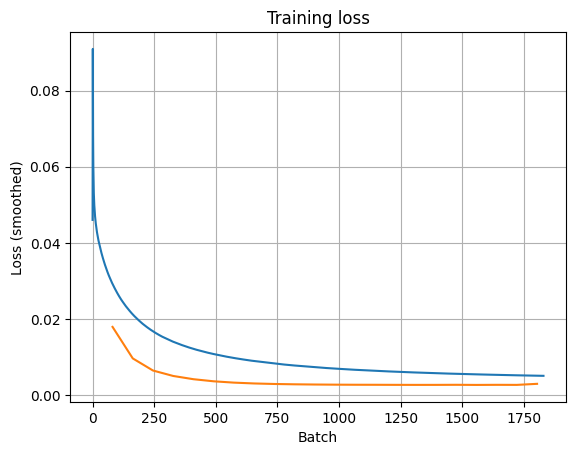

In [19]:
from ember.callback import TensorboardCallback

def loss_fn(x, out, tgt):
    assert isinstance(x, TensorWrapper)
    assert torch.isfinite(out).all(), "out has NaNs/Infs, likely from gradient explosions"
    assert torch.isfinite(tgt).all(), "tgt has NaNs/Infs, likely from input data"
    seq, mask = x.get()
    mse = (abs(out - tgt) ** 2 * mask).sum() / mask.sum()

    pred_mag = (out.abs() * mask).sum() / mask.sum()
    tgt_mag = (tgt.abs() * mask).sum() / mask.sum()
    collapse_penalty = torch.relu(0.1 * tgt_mag - pred_mag)

    return mse + 0.1 * collapse_penalty

learner = Learner(Model(), torch.optim.AdamW, train_loader, test_loader, loss_fn=loss_fn, clip_grads=1, compile_model=False)

learner.add_cb(TensorboardCallback())

learner.fit_one_cycle(num_epochs, max_lr=1e-3)

learner.recorder.plot_loss()